# Automated Discovery of Temperature Dependent Structural Change

    Neutron powder diffraction is a powerful way to examine the atomic structure of technologically interesting materials. The particular material from this data set is a candidate for solar cells . Nevertheless, the same methods are used in battery materials, catalysts, etc. A single data set has 2 dimensions: Intensity(I) and d spacing (d). The d spacing is a characteristic structural scale in the system. If there is a large I at a given d, that means there are at least two atoms spaced at that distance in the system. If I is at the background it means there is nothing with that d spacing in the material.
    
    Often functional behavior is related to a structural change with an external parameter like temperature. This structural change show up as change in the existence, position or width of the peaks. The provided data set is a collection of I vs d curves at multiple temperatures. So the data set is 3 dimensional I(d,T). The data is in an HDF5 file. H5py is a useful set of libraries for accessing HDF5 files from python. If you are not familiar with hdf5 and want to browse the data structure want to browse the data structure we recommend hdfview or nexpy. However, the developed algorithms should run independently of these codes.

# Challenge
    Given the aforementioned data set, here are the challenge questions
    
    1. Provide an algorithm that given the data set as an input, provides the temperature of the structural transition.
    2. Provide an algorithm that gives the integrated area under, the center of intensity, and a characteristic width for the peak that is between 3.2 and 3.3 Å in d spacing as a function of temperature.
    3. Provide an algorithm that gives the integrated area under, the center of intensity, and a characteristic width for all peaks at a given Temperature.
    4. Given adjacent temperatures, provide an algorithm that indicates if a phase transition occurred between the two temperatures, a list of centers, widths, and intensities for all peaks in the data set that are at least 1.5x above background in under 5 seconds

    Our preference is for the algorithms to be implemented in Python with use of the numpy library, other necessary libraries are welcome. If the participant prefers a compiled code, C/C++, is our preferred solution with the output being in a python or numpy data structure.

In [1]:
import numpy as np
np.set_printoptions(precision=3)
import scipy as sp
 
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
rc('text', usetex=True)
mpl.rcParams['savefig.dpi'] = 200
#%matplotlib notebook
%matplotlib inline
from IPython.core.pylabtools import figsize

#import h5py
from nexusformat.nexus import *
import warnings
warnings.filterwarnings('ignore')

import os
os.makedirs('Q1/Data/', exist_ok=True)
os.makedirs('Q1/Figs/', exist_ok=True)

# Q0. Load the data, display the tree structure, plot the data and convert the data into np arrays. 

In [2]:
ff = nxload('NPD_Temp.nxs')
data = ff.entry.data

'''to keep the nexus format. The data format is slightly difffernt to np array.'''
#_intsy = data['intensity']
#_QQs = data['Q']
#_dds = data['dspacing']
#_temps = data['temperature']

'''convert to numpy array'''
intsy = np.asarray(data['intensity'])
QQs = np.asarray(data['Q'])
dds = np.asarray(data['dspacing'])
temps = np.asarray(data['temperature'])
dd_cs = (dds[:-1]+dds[1:])/2
temp_cs = (temps[:-1]+ temps[1:])/2

# Q1. Provide an algorithm that given the data set as an input, provides the temperature of the structural transition.


## 1.1 Using correlation method to measure the similarity of two data sets, the change of which is used as an indication of structural phase transition. 

    Calcualte the normalized covariance matrix: Pearson's correlation function.
    
    scipy.stats.stats.pearsonr() return CORR; but the scipy.spatial.distance.pdist() returns 1-CORR.
    We report 1-CORR here.
   

In [3]:
'''
Pearson's correlation function.
'''
def Cal_NNCorr(IntsyMap):
    '''
    Call scipy.stats.stats.pearsonr() to calculate Pearson's correlation function between two consecutive 
    datasets from a 2D map.
    '''
    from scipy.stats.stats import pearsonr
    
    npars, _ = IntsyMap.shape
    NNCorr = np.empty(npars-1)
    
    for ii in range(npars-1):
        NNCorr[ii], _ = pearsonr(IntsyMap[ii, :], IntsyMap[ii+1, :])
       
    return 1-NNCorr

def Cal_Corr_2D(IntsyMap, metric = 'correlation' ):
    '''
    Call sp.spatial.distance.pdist() to the full 2D Pearson's correlation function from a 2D map.
    '''
    from scipy.spatial.distance import pdist
    
    Corr_half = pdist(np.asarray(IntsyMap), metric)
    
    npars, _ = IntsyMap.shape
    Corr_2D = np.ones((npars-1, npars-1))
    inds = np.triu_indices_from(Corr_2D)
    Corr_2D[inds] = Corr_half
    Corr_2D[inds[1], inds[0]] = Corr_half
    
    return Corr_2D

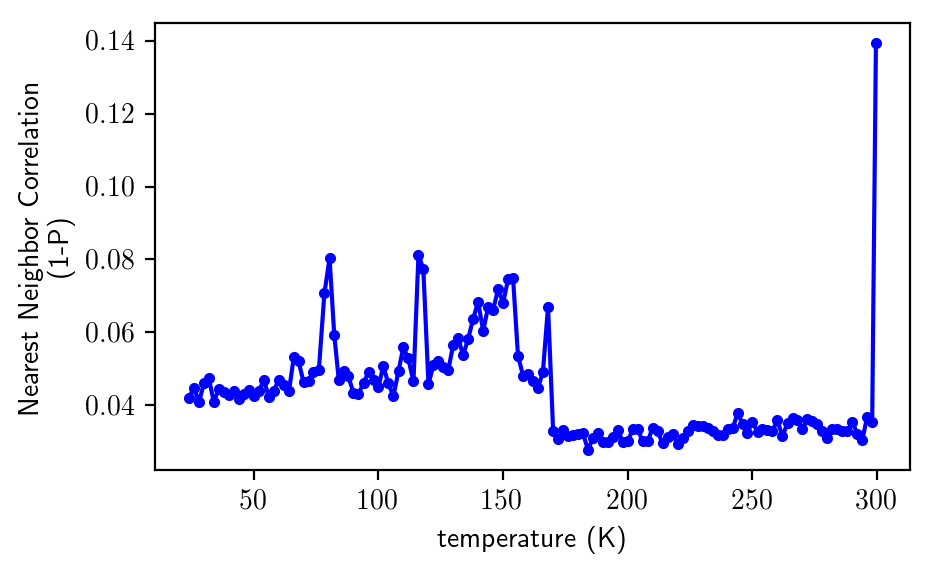

In [4]:
NNCorr = Cal_NNCorr(intsy)
np.save('Q1/Data/NNCorr', NNCorr)

plt.figure(figsize(4.8, 3))
plt.plot(temp_cs, NNCorr, '.-', color='b')
plt.xlabel('temperature (K)')
plt.ylabel('Nearest Neighbor Correlation \n (1-P)')
plt.tight_layout()
plt.savefig('Q1/Figs/NNCorr.png')

#''' convert to nexus format to plot the results'''
#_NNCorr = NXdata(NXfield(NNCorr, "Nearest Neighbor Correlation \n (1-P)"),_temps)
#mpl.rcParams.update(mpl.rcParamsDefault)
#figsize(5, 3)
#_NNCorr.plot('.-')

### 1.2 Using wavelt transform peak finding algorithm to find the structural transition temperatures. 
    
    Use the default symmetric ricker wavelet.

In [5]:
def _peak_cleanup_by_distance(peakindx, min_dis, lens=0):
    ''' 
    
    Define a quick way to remove one of the higher-indexed (index: ii+1) peak if two adjacent 
    peaks are too close to each other,  unless the lower-indexed peak (ii) has been removed 
    and the distance between peaks ii+1 and ii-1 is more thatn min_dis. 
    No more iterations is checked beyond this. 
    There is an option to remove peaks too close to the edges, if lens is defined.
    --
    Input: 
        peak index array.
        minimum index distance.
    Output:
        A new peak index array
    '''
    
    if lens > 0:
        peakindx = peakindx[peakindx > min_dis]
        peakindx = peakindx[peakindx < (lens - min_dis)]
    
    npeaks = peakindx.size
    if npeaks > 0:
        unique_peak=[peakindx[0]]
    else:
        return np.asarray([])
    
    if npeaks > 1:
        dist = peakindx[1:] - peakindx[:-1]
        ii=0
        for ii in range(dist.size):
            if dist[ii] >= min_dis:
                unique_peak.append(peakindx[ii+1])
            elif ii>0 & (dist[ii]+dist[ii-1]) >= min_dis:
                unique_peak.append(peakindx[ii+1])

    
    return np.asarray(unique_peak)

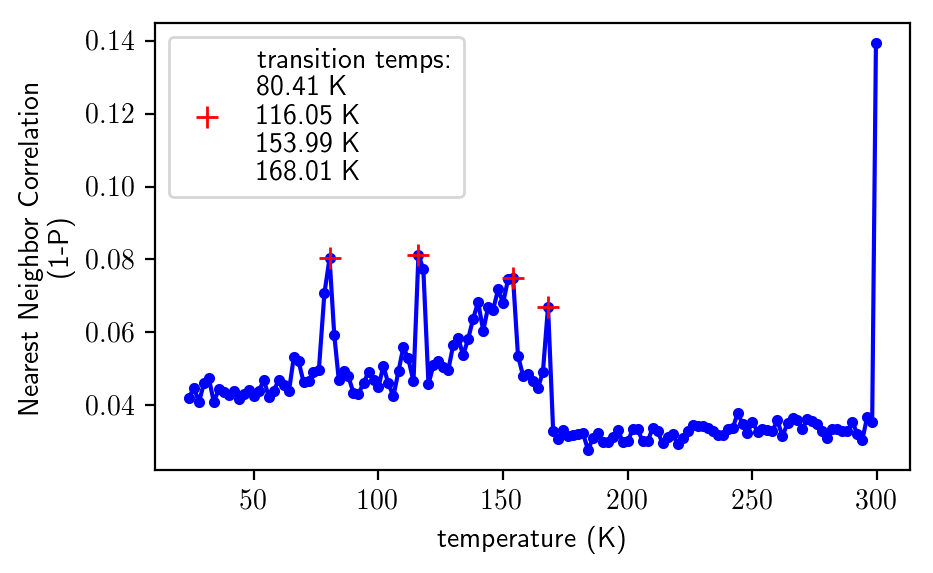

In [6]:
from scipy.signal import find_peaks_cwt

''' parameters for peak finding '''
wws = np.arange(0.5, 3, 0.4)
minlength = np.ceil(wws.size/4)
SNr = 3
min_dis = 3

_peak = find_peaks_cwt(NNCorr, wws, min_length = minlength, 
                       min_snr=SNr, noise_perc=25)
peaks = _peak_cleanup_by_distance(_peak, min_dis, lens=NNCorr.size)


label ='transition temps:'
for ii in peaks:
    label += '\n%4.2f K' %(temp_cs[ii]) 

plt.figure(figsize(4.8, 3))
plt.plot(temp_cs, NNCorr, '.-', color='b')
plt.plot(temp_cs[peaks], NNCorr[peaks], '+', color='red', markersize = 8, label = label)
plt.legend()
plt.xlabel('temperature (K)')
plt.ylabel('Nearest Neighbor Correlation \n (1-P)')
plt.tight_layout()
plt.savefig('Q1/Figs/NNCorr_peaks.png')

## 1.2.1 Discussion

    There are cleary 4 strong peaks found by (1-P). The last one at the highest temperature 300 K was caused by the high noise level of 300 K data, as found in Q0. There are not enough reference temperatures, and thus it was excluded by the peak-finding algorithm. 
    
    There is a pair of peaks at 80 K and 116 K, which are also related to high std in the background. Therefore, these two peaks could be also from noisy. However, we also see anomolies (kinks) at in the backgroud mean near 80 K and 116 K, therefore, it might be that there are structural transitions at these two temperatures. There is also an anomoly at 80 K in the total integrated intensity. If uncertainty had been given, we will have a better way to judge the origin of the 80 K and 116 K peaks.  

## 1.3  Generating 2D perason's correlation map to better visualize the results.

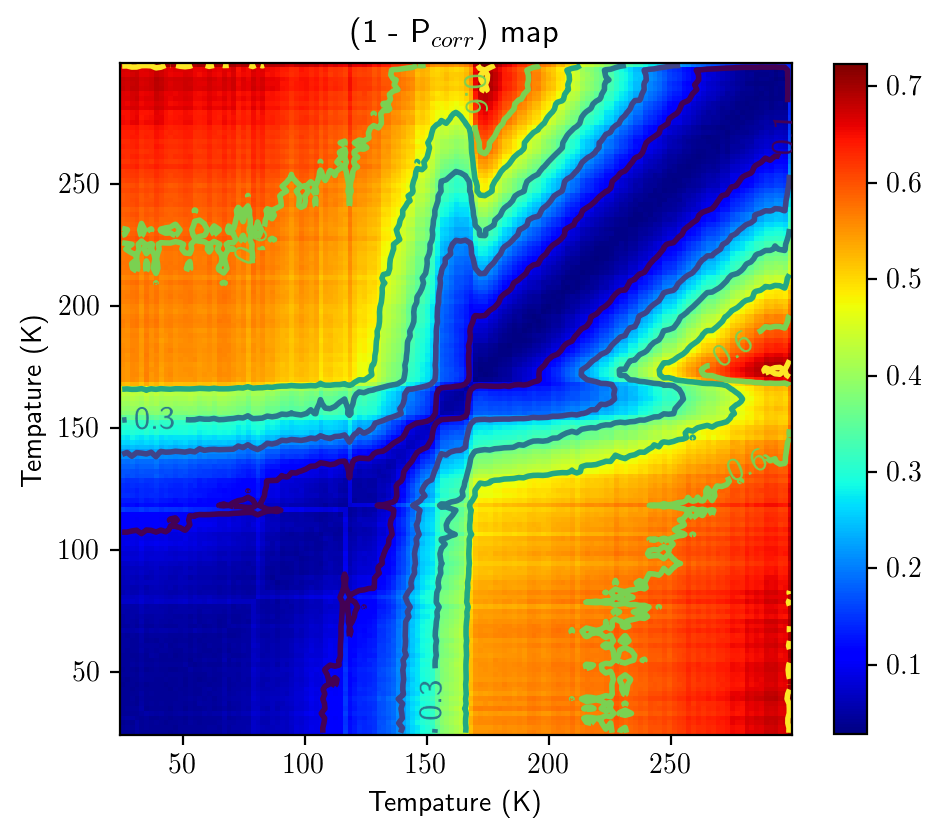

In [7]:
corr2D = Cal_Corr_2D(intsy)
np.save('Q1/Data/Corr_2DMap', corr2D)

plt.figure(figsize=(5, 5))
rc('text', usetex=True)
T_min, T_max = temp_cs.min(), temp_cs.max() 
im = plt.imshow(corr2D, interpolation='None', origin='lower', cmap='jet', extent=(T_min, T_max, T_min, T_max))

lowlim, highlim =  np.ceil(corr2D.min()*10)/10, np.floor(corr2D.max()*10)/10
levels = np.linspace(lowlim, highlim, 6)
CS = plt.contour(corr2D, levels, origin='lower',linewidths=2, extent=(T_min, T_max, T_min, T_max))
plt.xlabel('Tempature (K)')
plt.ylabel('Tempature (K)')
plt.clabel(CS, levels[0::2], inline=1, fmt='%1.1f', fontsize=12)
plt.colorbar(im, shrink=0.725)
plt.title('(1 - P$_{corr}$) map')
plt.tight_layout()
plt.savefig('Q1/Figs/Pearson_correlation_map.png')

## 1.4  Alternative solution: calculating the distance between adjacent dataset and generate a 2D map and finding the transition temperatures. 

    introduce a parameter alpha to calcualte the distance between two datasets.  

In [8]:
# from numpy import linalg as LA
# numpy.linalg.norm(x, ord=None, axis=None, keepdims=False)

def Cal_NNDistance(IntsyMap, alpha=0.25):
    '''
    
    '''
    IntsyMap_T = IntsyMap.T
    IntsyMap_dev = IntsyMap_T - IntsyMap_T.mean(0)
    
    return _Cal_NNDistance(IntsyMap_dev.T, alpha)

def Cal_DistanceMap(IntsyMap, alpha=0.25):
    '''
    
    '''
    IntsyMap_T = IntsyMap.T
    IntsyMap_dev = IntsyMap_T - IntsyMap_T.mean(0)
    
    return _Cal_DistanceMap(IntsyMap_dev.T, alpha)


def _Cal_NNDistance(IntsyMap, alpha = 1):
    '''
    
    '''
    from numpy import linalg as LA
    
    npars, _ = IntsyMap.shape
    NNDist = np.zeros(npars-1)
    
    for ii in range(npars-1):
        #NNDist[ii] = LA.norm((IntsyMap[ii] - IntsyMap[ii+1]), alpha)
         NNDist[ii] = LA.norm(IntsyMap[ii] - IntsyMap[ii+1])**alpha
 
    return NNDist


def _Cal_DistanceMap(IntsyMap, alpha=1):
    '''
    
    '''
    from numpy import linalg as LA
    
    npars, _ = IntsyMap.shape
    Distance_2D = np.zeros((npars-1, npars-1))
 
    for ii in range(npars-1):
        for jj in range(ii):
            #val = LA.norm((IntsyMap[ii] - IntsyMap[ii+1]), alpha)
            val = LA.norm(IntsyMap[ii] - IntsyMap[ii+1])**alpha
            Distance_2D[ii][jj] = val
            Distance_2D[jj][ii] = val
  
    return Distance_2D

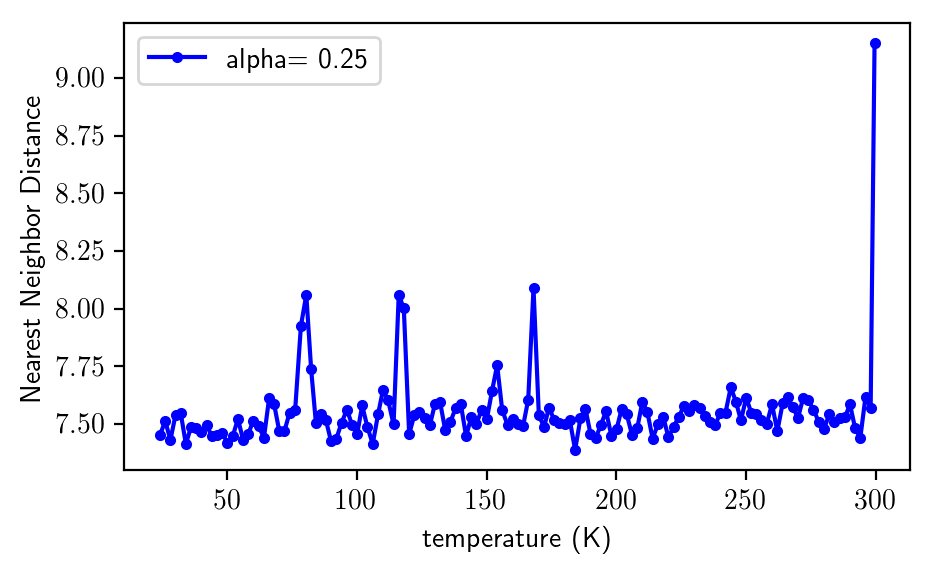

In [9]:
alpha = 0.25
NNDist = Cal_NNDistance(intsy, alpha)
np.save('Q1/Data/NNDist_alpha_p25.txt', NNDist)

plt.figure(figsize(4.8, 3))
label = 'alpha= %4.2f' %(alpha)
plt.plot(temp_cs, NNDist, '.-', color='b', label=label)
plt.xlabel('temperature (K)')
plt.ylabel('Nearest Neighbor Distance')
plt.legend()
plt.tight_layout()
#plt.savefig('Q1/Figs/NNDist_alpha_p25.png')

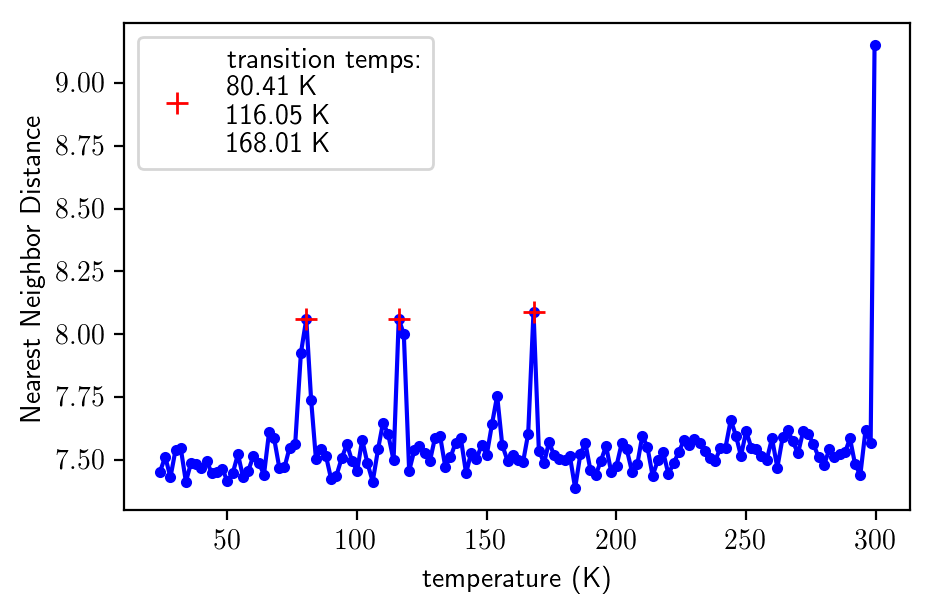

In [10]:
wws = np.arange(0.5, 3.5, 0.5)
minlength = np.ceil(wws.size/4)
SNr = 1.25
min_dis = 3

_peaks = find_peaks_cwt(NNDist, wws, min_length = minlength, 
                       min_snr=SNr, noise_perc=10)
peaks = _peak_cleanup_by_distance(_peaks, min_dis, lens=NNDist.size)

label ='transition temps:'
for ii in peaks:
    label += '\n%4.2f K' %(temp_cs[ii]) 

plt.figure(figsize(4.8, 3.2))
npeaks = peaks.size
plt.plot(temp_cs, NNDist, '.-', color='b')
plt.plot(temp_cs[peaks], NNDist[peaks], '+', color='red', markersize = 8, label = label)
plt.legend()
plt.xlabel('temperature (K)')
plt.ylabel('Nearest Neighbor Distance')
plt.tight_layout()
plt.savefig('Q1/Figs/NNDist_alpha_p25_wpeaks.png')

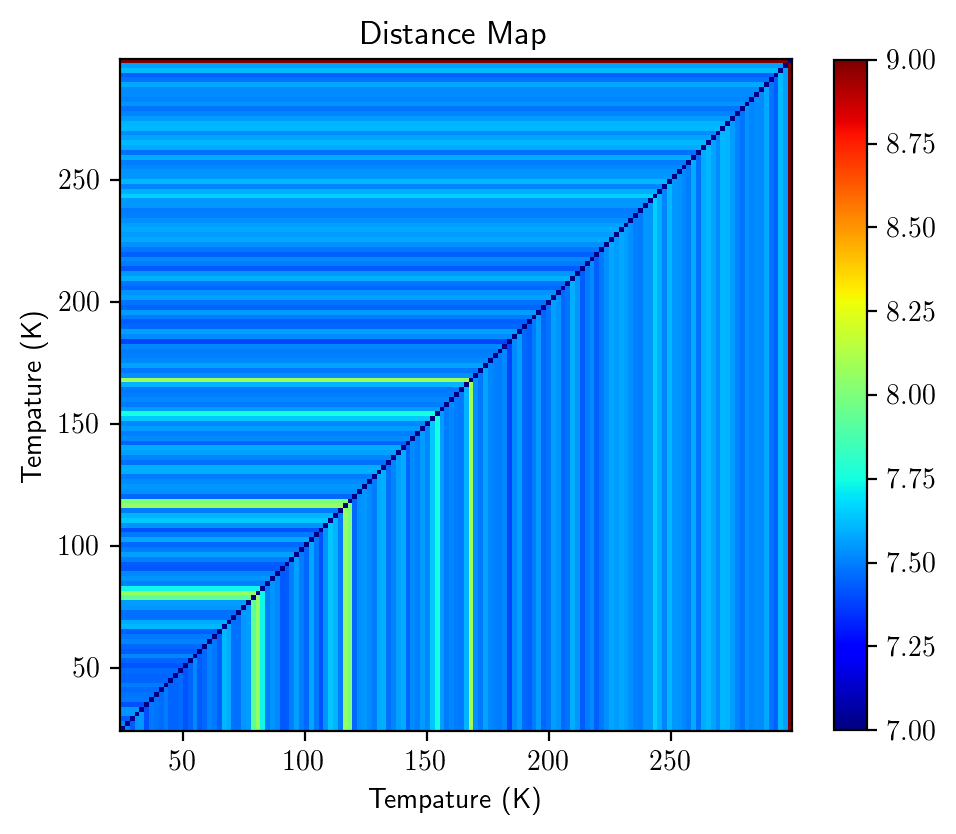

In [20]:
alpha = 0.25
Distance2D = Cal_DistanceMap(intsy, alpha)
np.save('Q1/Data/Dist_2DMap', Distance2D)
#__Distance2D = NXfield(Distance2D, "Distance Map")
#_DistMap = NXdata(__Distance2D,(_temps, _temps))
figsize(5, 4.2)
#_DistMap.plot()



plt.figure(figsize=(5, 5))
rc('text', usetex=True)
T_min, T_max = temp_cs.min(), temp_cs.max() 
im = plt.imshow(Distance2D, interpolation='None', clim=(7, 9),
                origin='lower', cmap='jet', extent=(T_min, T_max, T_min, T_max))
plt.xlabel('Tempature (K)')
plt.ylabel('Tempature (K)')
plt.colorbar(im, shrink=0.725)
plt.title('Distance Map')
plt.tight_layout()
plt.savefig('Q1/Figs/Pearson_correlation_map.png')